# Systematic Trading - Deep Learning
---
 
 
- Copyright (c) Imperial College London, 2024. All rights reserved

- Author: Guangyi He (<g.he23@imperial.ac.uk>)

- Platform: Tested on Windows 11 with Python 3.11

# Portfolio Construction with Deep Learning Approach

In [2]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

Before we start: check if GPU is available.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on {device}")

running on cuda


# What do we need to train a neual network?
1. Data Generator
2. Network
3. Loss function
4. evaluation function
5. Optimizer

## 1. Data Generator

Generate sequences of signal defined in the lecture: 

$$
\mu_t = \phi \mu_{t-1} + \epsilon_t.
$$

In [4]:
class data_generator():
    def __init__(self, phi, sequnce_length):
        self.phi = phi
        self.sequence_length = sequnce_length

    def generate(self, size):
        mu = torch.zeros((size, self.sequence_length))
        epsilon = torch.normal(0., 1.,(size, self.sequence_length))
        for i in range(1, self.sequence_length):
            mu[:,i] = self.phi * mu[:,i-1] + (1-self.phi**2)**0.5*epsilon[:,i]
        return mu
    
    def generate_next_time(self, mu):
        eta = torch.normal(0., 1., (mu.size(0),))
        mu_next = self.phi * mu + (1-self.phi**2)**0.5*eta
        return mu_next

## 2.Network

In this problem, we want to find a function $h_\theta$ such the the current holidng $x_t = h_\theta(\mu_t,x_{t-1})$. The decision is made intependent of time, hence $h_\theta$ is applied iteratively. This structure leads to a simple RNN Network.

In [5]:
class RNN_simple(nn.Module):
    def __init__(self,
                 ):
        super(RNN_simple, self).__init__()
        self.rnn = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            )
    def forward(self, input):
        input = input.unsqueeze(-1) * 1.2e6 #make sure that the input and output are in the same scale
        input = input.transpose(0, 1) # change batch dim and time dim
        sequence_length = input.shape[0]
        output = torch.Tensor([]).to(device)
        output_0 = torch.zeros(input.shape[1], 1).to(device)
        for i in range(sequence_length):
            if i==0:
                input_hidden = torch.cat((input[i], output_0), dim = 1)
                output_i = self.rnn(input_hidden)
            else:
                input_hidden = torch.cat((input[i], output[i-1]), dim = 1)
                output_i = self.rnn(input_hidden)
            output = torch.cat((output, output_i.unsqueeze(0)), dim = 0 )
        return output.transpose(0, 1)

## 3. Loss function

For other tasks like regression and image detection, we can use the loss function in the the torch.nn package. e.g. nn.CrossEntrpyLoss(), nn.MESloss(). But in this task, we need to define our custom loss.

Recall the objective function is
$$
\sum_{t=0}^T \Big( \beta \mu_t x_t - \frac{\gamma\sigma^2}{2} x_t^2 - c(\Delta x_t) \Big).
$$

Notice that we need to maximize the above function, so in the training, we minimize the funtion with opposite sign.

In [6]:
class loss(nn.Module):
    def __init__(self, gamma, sigma, beta, lambda_q, q):
        super(loss, self).__init__()
        self.sigma = sigma
        self.gamma = gamma
        self.beta = beta
        self.lambda_q = lambda_q
        self.q = q
    def forward(self,
                x,
                mu,
               ):
        loss_return = self.beta*x*mu
        loss_risk_sq = (self.sigma**2)*x.square()
        loss_cost = self.lambda_q*(torch.diff(x,dim=1,prepend=x[:,0:1])).abs().pow(self.q)
        loss = loss_return - 0.5 * self.gamma * loss_risk_sq - loss_cost
        return -loss.mean()

## 4. Evluation Function

During the training, we want to know more about the strategy other than the loss. The Sharpe Ratio (SR) is a good indicator, which is defined as
$$
SR = \frac{return-cost}{risk}.
$$
In this function, we also output each compenent of SR.

In [7]:
class Sharp_Ratio(nn.Module):
    def __init__(self, sigma, beta, lambda_q, q):
        super(Sharp_Ratio, self).__init__()
        self.sigma = sigma
        self.beta = beta
        self.lambda_q = lambda_q
        self.q = q
    def forward(self,
                x,
                mu, 
               ):
        E_return = (self.beta*x*mu).mean()
        risk_sq = (self.sigma**2*x.square()).mean()
        risk = risk_sq.sqrt()
        cost = (self.lambda_q*torch.diff(x,dim=1,prepend=x[:,0:1]).abs().pow(self.q)).mean()
        return {'SR':((E_return-cost)/risk).item(),
                'return': E_return.item(),
                'cost': cost.item(),
                'risk': risk.item()}

## 5. Optimizer

 We don't need to write our own optimizer. Use ADAM in pytorch package.

# What we do in one epoch?
1. generate signal $\mu$
2. feed $\mu$ into the network, get position $x$
3. feed $\mu$ and $x$ into the loss.
4. Backpopagate from the loss.(if no opt, skip this)
5. Evaluate the result.

In [8]:

def epoch(generator, network, loss_fn, SR_fn, opt=None):
    total_loss=0.
    x_total = torch.Tensor([])
    mu_total = torch.Tensor([])
    for b in tqdm(range(0, batch_num)):
        mu = generator.generate(batch_size).to(device)
        x = network(mu).squeeze()
        loss = loss_fn(x, mu)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total_loss += loss.item()
        x_total = torch.cat((x_total,x.cpu().detach().clone()), dim=0)
        mu_total = torch.cat((mu_total,mu.cpu().detach().clone()), dim=0)
    SR_result = SR_fn(x_total, mu_total)
    SR_result['loss'] = -total_loss / batch_num
    return SR_result

# Parameter
This cell contain parameters of the model.

In [9]:
lambda_q = 1.35e-7
q = 1.6
beta = 1.67e-4 
sigma = 0.02
phi = 0.87

This cell constain parameters for the training

In [10]:
gamma = 6e-8
batch_size = 1024
sequence_length = 512
batch_num = 50
epoch_num = 15
lr = 1e-4

# Define the following
1. Data Generator
2. Network
3. Loss function
4. Evaluation function
5. Optimizer

In [11]:
generator = data_generator(phi, sequence_length)
network = RNN_simple().to(device)
loss_fn = loss(gamma, sigma, beta, lambda_q, q).to(device)
SR_fn = Sharp_Ratio(sigma, beta, lambda_q, q).to(device)
opt = torch.optim.Adam(network.parameters(), lr=lr)

# Training

In [12]:
# training
for i in range(epoch_num):
    print(f"epoch {i+1}")
    train_result = epoch(generator, network, loss_fn, SR_fn, opt)
    print(train_result)
    test_result = epoch(generator, network, loss_fn, SR_fn)
    print(test_result)
    

epoch 1


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


{'SR': 0.003389251884073019, 'return': 2.169374942779541, 'cost': 0.3823084235191345, 'risk': 527.2745971679688, 'loss': 1.7787259864807128}


100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


{'SR': 0.005373159423470497, 'return': 5.476629257202148, 'cost': 0.8744217157363892, 'risk': 856.5179443359375, 'loss': 4.580198650360107}
epoch 2


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


{'SR': 0.005276333540678024, 'return': 8.281490325927734, 'cost': 1.619674563407898, 'risk': 1262.584228515625, 'loss': 6.613992176055908}


100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


{'SR': 0.005300057120621204, 'return': 11.460814476013184, 'cost': 2.5726730823516846, 'risk': 1676.98974609375, 'loss': 8.803771896362305}
epoch 3


100%|██████████| 50/50 [00:19<00:00,  2.63it/s]


{'SR': 0.0050595286302268505, 'return': 15.573153495788574, 'cost': 4.095437049865723, 'risk': 2268.53466796875, 'loss': 11.3233278465271}


100%|██████████| 50/50 [00:08<00:00,  6.22it/s]


{'SR': 0.00499820476397872, 'return': 20.397130966186523, 'cost': 5.993415355682373, 'risk': 2881.777587890625, 'loss': 14.154575519561767}
epoch 4


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


{'SR': 0.004808939062058926, 'return': 26.83597183227539, 'cost': 8.781540870666504, 'risk': 3754.348388671875, 'loss': 17.63157516479492}


100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


{'SR': 0.0047113229520618916, 'return': 34.1054801940918, 'cost': 12.104045867919922, 'risk': 4669.90576171875, 'loss': 21.3471932220459}
epoch 5


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


{'SR': 0.00459818821400404, 'return': 42.18727493286133, 'cost': 15.635950088500977, 'risk': 5774.30126953125, 'loss': 25.55105182647705}


100%|██████████| 50/50 [00:07<00:00,  6.75it/s]


{'SR': 0.004573005251586437, 'return': 51.57432556152344, 'cost': 19.580556869506836, 'risk': 6996.2236328125, 'loss': 30.52535774230957}
epoch 6


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


{'SR': 0.004414184484630823, 'return': 64.65010070800781, 'cost': 24.9438533782959, 'risk': 8995.1484375, 'loss': 37.27886463165283}


100%|██████████| 50/50 [00:07<00:00,  6.45it/s]


{'SR': 0.004373291507363319, 'return': 82.404296875, 'cost': 31.591354370117188, 'risk': 11618.9248046875, 'loss': 46.762958984375}
epoch 7


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


{'SR': 0.0037629245780408382, 'return': 126.28550720214844, 'cost': 44.25791931152344, 'risk': 21798.892578125, 'loss': 67.77183464050293}


100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


{'SR': 0.0035434758756309748, 'return': 224.7611541748047, 'cost': 67.41349029541016, 'risk': 44404.890625, 'loss': 98.19384719848632}
epoch 8


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]


{'SR': 0.003648921847343445, 'return': 221.8017120361328, 'cost': 66.14155578613281, 'risk': 42659.21875, 'loss': 101.0658966064453}


100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


{'SR': 0.003736484330147505, 'return': 225.90550231933594, 'cost': 66.95669555664062, 'risk': 42539.66796875, 'loss': 104.66011260986328}
epoch 9


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


{'SR': 0.0038448150735348463, 'return': 230.5039825439453, 'cost': 69.15308380126953, 'risk': 41965.83984375, 'loss': 108.51694946289062}


100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


{'SR': 0.00396864814683795, 'return': 239.77755737304688, 'cost': 73.1285171508789, 'risk': 41991.38671875, 'loss': 113.75077072143554}
epoch 10


100%|██████████| 50/50 [00:17<00:00,  2.80it/s]


{'SR': 0.004160669166594744, 'return': 259.727783203125, 'cost': 81.04591369628906, 'risk': 42945.46484375, 'loss': 123.3525114440918}


100%|██████████| 50/50 [00:07<00:00,  6.65it/s]


{'SR': 0.0043924166820943356, 'return': 292.95440673828125, 'cost': 93.40411376953125, 'risk': 45430.63671875, 'loss': 137.632001953125}
epoch 11


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]


{'SR': 0.0044186972081661224, 'return': 336.46429443359375, 'cost': 103.74124908447266, 'risk': 52667.796875, 'loss': 149.506142578125}


100%|██████████| 50/50 [00:07<00:00,  6.64it/s]


{'SR': 0.00442707072943449, 'return': 347.3184509277344, 'cost': 105.45339965820312, 'risk': 54633.203125, 'loss': 152.32141174316405}
epoch 12


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


{'SR': 0.004430885426700115, 'return': 347.4041442871094, 'cost': 105.39372253417969, 'risk': 54618.9765625, 'loss': 152.51344665527344}


100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


{'SR': 0.004431317560374737, 'return': 348.4715576171875, 'cost': 105.30838775634766, 'risk': 54873.7890625, 'loss': 152.82915802001952}
epoch 13


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]


{'SR': 0.004435427952557802, 'return': 347.7274169921875, 'cost': 105.10118865966797, 'risk': 54701.875, 'loss': 152.8573468017578}


100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


{'SR': 0.004419919569045305, 'return': 347.5350646972656, 'cost': 105.31043243408203, 'risk': 54802.94921875, 'loss': 152.12373413085936}
epoch 14


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]


{'SR': 0.0044308071956038475, 'return': 346.66839599609375, 'cost': 104.78540802001953, 'risk': 54591.1796875, 'loss': 152.47707916259765}


100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


{'SR': 0.004439882934093475, 'return': 348.7757568359375, 'cost': 105.2352523803711, 'risk': 54852.91015625, 'loss': 153.2752212524414}
epoch 15


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


{'SR': 0.004441276658326387, 'return': 348.3970642089844, 'cost': 105.13996124267578, 'risk': 54771.88671875, 'loss': 153.25834411621094}


100%|██████████| 50/50 [00:07<00:00,  6.38it/s]


{'SR': 0.004443072248250246, 'return': 347.4862976074219, 'cost': 104.8169174194336, 'risk': 54617.47265625, 'loss': 153.17735137939454}


# Evaluate the strategy with long sequence length

To get more accurate SR and compare it with other stategy available.

In [17]:
def SR_net(network):
    total_return = 0.
    total_risksq = 0.
    total_cost = 0.
    loop_num = 1
    sample_size = 1000
    time_sequence = 250*100
    mu_t = torch.zeros(sample_size)
    x_t = torch.zeros(sample_size)
    x_t_minus_1 = torch.zeros(sample_size)
    with torch.no_grad():
        for t in tqdm(range(time_sequence)):
            input = torch.cat((mu_t.unsqueeze(-1)*1.2e6, x_t_minus_1.unsqueeze(-1)), dim = 1).to(device)
            x_t = network.rnn(input).squeeze().to('cpu')
            returnn = beta*(x_t * mu_t).mean()
            risksq =((sigma**2) * (x_t**2)).mean()
            cost = (lambda_q * (torch.abs(x_t-x_t_minus_1) ** q)).mean()
            total_return += returnn.item()
            total_risksq += risksq.item()
            total_cost += cost.item()
            x_t_minus_1 = x_t
            mu_t= generator.generate_next_time(mu_t)
    re = total_return / time_sequence / loop_num
    ri = (total_risksq / time_sequence/ loop_num)**0.5
    co = total_cost / time_sequence / loop_num
    return {'SR':(re-co)/ri,
                'return': re,
                'cost': co,
                'risk': ri}

def SR_linear():
    total_return = 0.
    total_risksq = 0.
    total_cost = 0.
    loop_num = 1
    sample_size = 1000
    time_sequence = 250*100
    mu_t = torch.zeros(sample_size)
    x_t = torch.zeros(sample_size)
    x_t_minus_1 = torch.zeros(sample_size)
    with torch.no_grad():
        for t in tqdm(range(time_sequence)):
            x_t = 525617.5 * mu_t + 0.8632 * x_t_minus_1
            returnn = (beta * x_t * mu_t).mean()
            risksq =((sigma**2) * (x_t**2)).mean()
            cost = (lambda_q * (torch.abs(x_t-x_t_minus_1) ** q)).mean()
            total_return += returnn.item()
            total_risksq += risksq.item()
            total_cost += cost.item()
            x_t_minus_1 = x_t
            mu_t= generator.generate_next_time(mu_t)
    re = total_return / time_sequence / loop_num
    ri = (total_risksq / time_sequence/ loop_num)**0.5
    co = total_cost / time_sequence / loop_num
    return {'SR':(re-co)/ri,
                'return': re,
                'cost': co,
                'risk': ri}

In [18]:
SR_net(network)

100%|██████████| 25000/25000 [00:09<00:00, 2724.12it/s]


{'SR': 0.0044680155400649655,
 'return': 351.86431553970334,
 'cost': 105.48762319732674,
 'risk': 55142.308734851504}

Result of Linear Strategy

In [19]:
SR_linear()

100%|██████████| 25000/25000 [00:01<00:00, 14154.10it/s]


{'SR': 0.004453132132745876,
 'return': 352.30006693359377,
 'cost': 106.51109779586793,
 'risk': 55194.62746913109}

Result of a better strategy

In [20]:
network_op = torch.load('RNN_simple.pt',map_location=torch.device('cpu')).to(device)
SR_net(network_op)

100%|██████████| 25000/25000 [00:09<00:00, 2679.79it/s]


{'SR': 0.004500156966950673,
 'return': 358.3078261846161,
 'cost': 106.62475961110621,
 'risk': 55927.619507914955}

## Plot

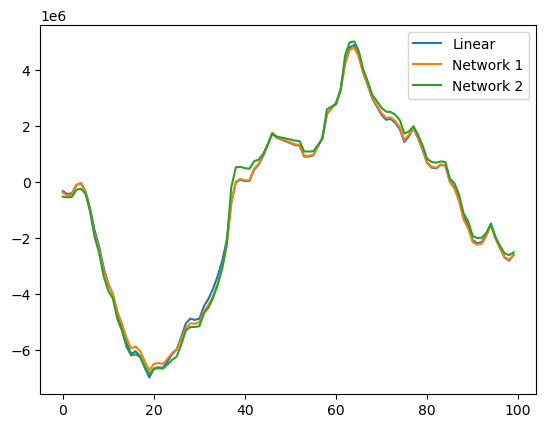

In [28]:
mu = generator.generate(1).to(device)
x_net1 = network(mu).squeeze().to('cpu').detach().numpy()
x_net2 = network_op(mu).squeeze().to('cpu').detach().numpy()
mu = mu.squeeze().to('cpu')
x_linear = torch.zeros(sequence_length)
for i in range(1, sequence_length):
    x_linear[i] = 525617.5 * mu[i] + 0.8632 * x_linear[i-1]

a=200
b=300
plt.plot(x_linear[200:300], label='Linear')
plt.plot(x_net1[200:300], label='Network 1')
plt.plot(x_net2[200:300], label='Network 2')
plt.legend()
plt.show()
